# PREDICTING BANK PRODUCT SUBSCRIPTION

Authors:

Miguel Ramos Cabañas 100473854

Miguel

## Libraries Import

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.proportion import proportion_confint

## Data Import

We use the last 2 digits from the NIA from the first author. As a consequence, we select the data folder **bank_54**.

We import data as a pandas dataframe for simplicity.

In [26]:
data = pd.read_pickle('P1_assignment_dataset_bank_ALL/bank_54.pkl')

print(data.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


### VARIABLE DESCRIPTION

| Variable | Short Description |
| :--- | :--- |
| **age** | age in years |
| **job** | type of job |
| **marital** | marital status |
| **education** | education level |
| **default** | has credit in default? |
| **balance** | average yearly balance |
| **housing** | has a housing loan? |
| **loan** | has a personal loan? |
| **contact** | contact communication type |
| **day_of_week** | last contact day |
| **month** | last contact month |
| **duration** | last contact duration, in seconds |
| **campaign** | number of contacts performed during this campaign and for this client |
| **pdays** | number of days that passed by after the client was last contacted from a previous campaign. The value is -1 if no/unknown contact was produced. |
| **previous** | number of contacts performed before this campaign and for this client |
| **poutcome** | outcome of the previous marketing campaign |
| **deposit** | has the client subscribed a term deposit? **TARGET VARIABLE** |

## Simplified EDA

From the initial import, we can observe that we are in a **classification problem** where our target variable is binary: Yes , No. 
Answering the question if the client has subscribed a term deposit.

In [27]:
print("The number of rows in the dataset is:", len(data), "and the number of columns is:", len(data.columns))

The number of rows in the dataset is: 11000 and the number of columns is: 17


We first need to analyze the proportion for the target variable to decide the training / test partition strategy we are going to choose.

In [28]:
data['deposit'].value_counts(normalize=True)


deposit
no     0.525455
yes    0.474545
Name: proportion, dtype: float64

## Definition of the Outer and Inner Evaluation

We think that the holdout method is enough for 

To do:
- Explicar porque usamos holdout para outer y cv para inner.
- Explicar porque usamos 80/20. Hacer referencia al tamaño muestral mínimo necesario para estimar intervalos de confianza en el test suficientemente grandes (Página 20, Tema3).

In [29]:
# 1. ANALYSIS FUNCTION 
def analyze_test_accuracy(data, target_col, test_sizes=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    """
    We analyze the effect of different test sizes on accuracy estimates using a decision tree.
    We return a DataFrame including estimated accuracy, Clopper-Pearson confidence intervals, and their widths.
    Note: This methology was extracted from the notion of Binomial/Beta distribution in Topic 3 for selecting optimal test size.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]


    # Identify categorical columns and apply OneHotEncoder
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    print("Applying OneHotEncoder...")
    X_array = preprocessor.fit_transform(X)

    # Attempt to retrieve feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        feature_names = [f"feat_{i}" for i in range(X_array.shape[1])]

    X = pd.DataFrame(X_array, columns=feature_names)

    results = []
    print(f"Analyzing dataset with {len(data)} total instances...\n")

    for test_size in test_sizes:
        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=100473854
        )

        # Fit a decision tree as a proxy model
        clf = DecisionTreeClassifier(random_state=100473854, max_depth=5)
        clf.fit(X_train, y_train)

        # Compute accuracy and confidence intervals
        y_pred = clf.predict(X_test)
        n_test = len(y_test)
        correct_predictions = np.sum(y_pred == y_test)
        accuracy = correct_predictions / n_test

        # Clopper-Pearson (Beta) confidence interval
        ci_low, ci_high = proportion_confint(correct_predictions, n_test, alpha=0.05, method='beta')
        width = ci_high - ci_low

        # We store exact numerical values to ensure plotting accuracy
        results.append({
            'Test Size %': int(test_size*100),
            'N Test': n_test,
            'N Train': len(y_train),
            'Accuracy Est.': accuracy,
            'CI Low': ci_low,
            'CI High': ci_high,
            'CI Width': width
        })

    return pd.DataFrame(results)


In [30]:
# 2. PLOTTING FUNCTION
def plot_results(df, optimal_pct=15):
    """
    We visualize the accuracy estimates and confidence intervals for different test sizes.
    The first plot shows uncertainty vs. test size; the second shows error bars for estimated accuracy.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # -- PLOT 1: Uncertainty Curve --
    sizes = df['Test Size %']
    widths = df['CI Width']
    ax1.plot(sizes, widths, marker='o', linestyle='-', color='gray', label='Interval Width')

    # Highlight the optimal test size
    row_opt = df[df['Test Size %'] == optimal_pct]
    if not row_opt.empty:
        val_width = row_opt['CI Width'].values[0]
        ax1.scatter(optimal_pct, val_width, color='red', s=150, zorder=5, label=f'Selection ({optimal_pct}%)')
        ax1.axvline(x=optimal_pct, color='red', linestyle='--', alpha=0.5)
        ax1.annotate(f'Width: {val_width:.4f}',
                     xy=(optimal_pct, val_width), xytext=(optimal_pct+2, val_width+0.01),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    ax1.set_title('Uncertainty vs. Test Size\n(Smaller Width is Better)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Test Size (%)')
    ax1.set_ylabel('Interval Width')
    ax1.legend()

    # -- PLOT 2: Error Bars for Accuracy --
    y_err_low = df['Accuracy Est.'] - df['CI Low']
    y_err_high = df['CI High'] - df['Accuracy Est.']
    error_bars = [y_err_low, y_err_high]
    colors = ['red' if s == optimal_pct else 'skyblue' for s in sizes]

    ax2.errorbar(sizes, df['Accuracy Est.'], yerr=error_bars, fmt='none', ecolor='gray', elinewidth=2, capsize=5)
    ax2.scatter(sizes, df['Accuracy Est.'], s=100, c=colors, zorder=3)

    ax2.set_title('Statistical Accuracy (Real Confidence Intervals)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Test Size (%)')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


Applying OneHotEncoder...
Analyzing dataset with 11000 total instances...

Results Table:
 Test Size %  N Test  N Train  Accuracy Est.      CI 95% Text  CI Width
           5     550    10450       0.796364 [0.7602, 0.8293]  0.069014
          10    1100     9900       0.792727 [0.7676, 0.8163]  0.048777
          15    1650     9350       0.800000 [0.7799, 0.8191]  0.039186
          20    2200     8800       0.807727 [0.7906, 0.8240]  0.033377
          25    2750     8250       0.817455 [0.8025, 0.8317]  0.029231
          30    3300     7700       0.814545 [0.8009, 0.8277]  0.026818

Generating plots...


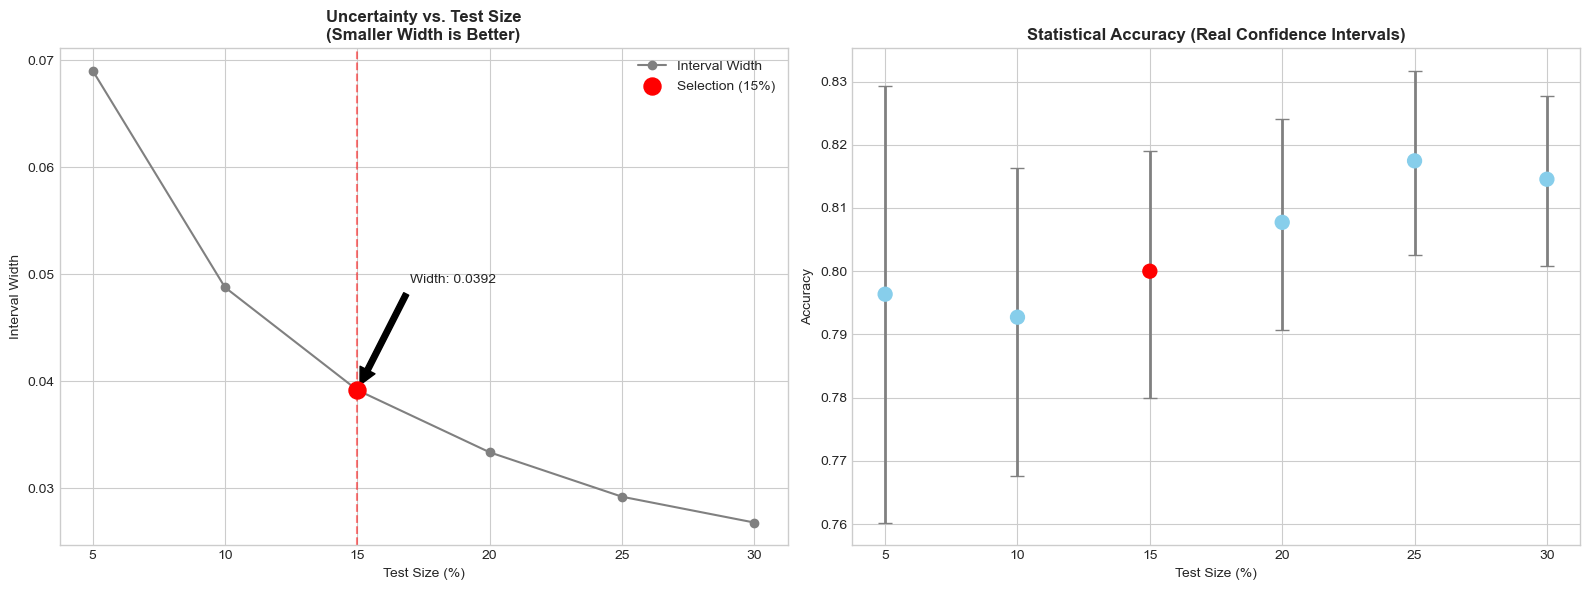

In [31]:
# MAIN EXECUTION
try:
    # 1. Run analysis (using the updated function above)
    df_res = analyze_test_accuracy(data, "deposit")  

    # 2. Print results table
    print("Results Table:")
    print_df = df_res.copy()
    print_df['CI 95% Text'] = print_df.apply(lambda x: f"[{x['CI Low']:.4f}, {x['CI High']:.4f}]", axis=1)
    cols_show = ['Test Size %', 'N Test', 'N Train', 'Accuracy Est.', 'CI 95% Text', 'CI Width']
    print(print_df[cols_show].to_string(index=False))

    # 3. Generate plots
    print("\nGenerating plots...")
    plot_results(df_res, optimal_pct=15)

except NameError:
    print("Error: Please ensure the variable 'data' is loaded before running.")
except Exception as e:
    print(f"An error occurred: {e}")

In [33]:
X = data.drop(columns='deposit') 
y = data['deposit']

# Split 85% train, 15% test: Optimal test size from analysis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,  
    random_state=100473854, 
    stratify=y       
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)

Tamaño X_train: (9350, 16)
Tamaño X_test: (1650, 16)


## Basic Methods

### KNN

### TREES

## Advanced Methods

## Results and Final Model

## Probability Calibration

## Open Choice Task